In [7]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('ticks')
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set number of parallel jobs
#N_JOBS = 24
N_JOBS = 6

# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 19 ms


In [8]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 167 ms


In [9]:
ds.close()

time: 22.8 ms


In [10]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 8.24 s


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from interpret.glassbox import ExplainableBoostingClassifier

def get_classifiers(random_seed=42):
    # From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    # Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
    classifiers = { 
        #'Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), 
        #                                  param_grid={'n_neighbors': [2, 4, 6, 8]}, 
        #                                  refit=True, cv=5, n_jobs=N_JOBS),
        'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}, 
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Random Forest': GridSearchCV(RandomForestClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 
                                                  'n_estimators': [6, 8, 10, 12, 14], 
                                                  'max_features': [1, 2, 3]},
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=1000, random_state=random_seed, 
                                                               class_weight='balanced'),
                                            param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                        'penalty': ['none', 'l2']},
                                            refit=True, cv=5, n_jobs=N_JOBS),
        'Linear SVM': GridSearchCV(SVC(kernel='linear', random_state=random_seed, 
                                       class_weight='balanced'),
                                   #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                   param_grid={'C': [1e-2, 1e-1, 1]},
                                   refit=True, cv=5, n_jobs=N_JOBS),
        'RBF SVM': GridSearchCV(SVC(kernel='rbf', random_state=random_seed, 
                                    class_weight='balanced'),
                                #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                param_grid={'C': [1e-2, 1e-1, 1]},
                                refit=True, cv=5, n_jobs=N_JOBS),
        'Neural Network': GridSearchCV(MLPClassifier(max_iter=1000, random_state=random_seed),
                                       param_grid={'alpha': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                   'hidden_layer_sizes': [(50,50,50), (100,)],
                                                   'activation': ['relu'],
                                                   'learning_rate': ['constant']},
                                       refit=True, cv=5, n_jobs=N_JOBS),
        'Explainable Boosting Machine': GridSearchCV(ExplainableBoostingClassifier(random_state=random_seed),
                                                     param_grid={'learning_rate': [0.01]},
                                                     refit=True, cv=5, n_jobs=1) # EBMs are trained with multiple cores
        }
    
    return classifiers

time: 22.6 ms


In [12]:
def remap_df(df_sklearn):
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    
    return df_sklearn_remapped, class_names

time: 14 ms


In [14]:
df_clf_results = pd.DataFrame(columns=['Classifier', 'Date', 'Crop type', 'Prec.', 'Recall', 
                                       'F1-Score', 'Accuracy', 'Samples', 'Random seed'])

#for random_seed in range(10):
for random_seed in range(1):
    print(f"\n\n########################## RANDOM SEED IS SET TO {random_seed:2d} ##########################") 
    # Seed the random generators
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

    # Get classifiers
    classifiers = get_classifiers(random_seed)
    
    # Add an extra month to the date range at each iteration in the loop
    year = 2018
    for i in range(7, 24, 1):
        month = (i % 12) + 1
        if month == 1:
            year += 1

        end_date = f'{year}-{month:02}-01'

        print(f"\n#########################################")
        print(f"# Dataset from 2018-07-01 to {end_date} #")
        print(f"#########################################\n")
        df_sklearn = get_sklearn_df(polygons_year=2019, 
                                    satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                    fields='all', 
                                    satellite='all', 
                                    polarization='all',
                                    crop_type='all')

        df_sklearn_remapped, class_names = remap_df(df_sklearn)

        # Get values as numpy array
        array = df_sklearn_remapped.values
        X = np.float32(array[:,5:])  # The features 
        y = np.int8(array[:,4])  # The column 'afgkode'
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, 
                                                            random_state=random_seed)

        for name, clf in classifiers.items():
            # Evaluate classifier
            print("-------------------------------------------------------------------------------")
            print(f"Evaluating classifier: {name}")
            clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(
                clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, plot_conf_matrix=False,
                print_classification_report=False)      
            print(f"The best parameters are {clf_trained.best_params_} (score = {clf_trained.best_score_:2f})")

            # Save results for individual crops in df
            df_results = pd.DataFrame(results_report).transpose()  
            for crop_type in class_names:
                # Get values
                prec = df_results.loc[crop_type, 'precision']
                recall = df_results.loc[crop_type, 'recall']
                f1 = df_results.loc[crop_type, 'f1-score']
                samples = df_results.loc[crop_type, 'support']
                acc = None

                # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
                df_clf_results.loc[-1] = [name, end_date, crop_type, prec, recall, f1, acc, samples, 
                                          random_seed]
                df_clf_results.index = df_clf_results.index + 1  # shifting index
                df_clf_results = df_clf_results.sort_index()  # sorting by index

            # Save overall results
            prec = df_results.loc['weighted avg', 'precision']
            recall = df_results.loc['weighted avg', 'recall']
            f1 = df_results.loc['weighted avg', 'f1-score']
            acc = df_results.loc['accuracy', 'f1-score']
            samples = df_results.loc['weighted avg', 'support']

            # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
            df_clf_results.loc[-1] = [name, end_date, 'Overall', prec, recall, f1, acc, samples, 
                                      random_seed]
            df_clf_results.index = df_clf_results.index + 1  # shifting index
            df_clf_results = df_clf_results.sort_index()  # sorting by index
    
            # Save df with results to disk
            save_path = PROJ_PATH / 'notebooks' / '04_ClassifyDuringSeason_results.pkl'
            df_clf_results.to_pickle(save_path)



########################## RANDOM SEED IS SET TO  0 ##########################

#########################################
# Dataset from 2018-07-01 to 2018-08-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 4.6561 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.3072
Test accuracy: 0.2748
The best parameters are {'max_depth': 8} (score = 0.279460)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.6786 s
Prediction time: 0.0235 s

Report:

Train accuracy: 0.5153
Test accuracy: 0.3204
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} (score = 0.321471)
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression


/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training time: 87.6536 s
Prediction time: 0.0012 s

Report:

Train accuracy: 0.2843
Test accuracy: 0.2786
The best parameters are {'C': 0.0001, 'penalty': 'none'} (score = 0.281420)
-------------------------------------------------------------------------------
Evaluating classifier: Linear SVM
Training time: 238.4239 s
Prediction time: 8.6344 s

Report:

Train accuracy: 0.3056
Test accuracy: 0.2952
The best parameters are {'C': 0.1} (score = 0.302746)
-------------------------------------------------------------------------------
Evaluating classifier: RBF SVM
Training time: 305.6867 s
Prediction time: 14.1303 s

Report:

Train accuracy: 0.3521
Test accuracy: 0.332
The best parameters are {'C': 1} (score = 0.333483)
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 413.8664 s
Prediction time: 0.0126 s

Report:

Train accuracy: 0.374
Test accuracy: 0.3509
The best parameters are {'activation': 'relu', 'a

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 1066.8443 s
Prediction time: 0.0077 s

Report:

Train accuracy: 0.3504
Test accuracy: 0.3264
The best parameters are {'learning_rate': 0.01} (score = 0.330014)

#########################################
# Dataset from 2018-07-01 to 2018-09-01 #
#########################################



/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 7.3553 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.3986
Test accuracy: 0.3232
The best parameters are {'max_depth': 10} (score = 0.316300)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 47.7204 s
Prediction time: 0.029 s

Report:

Train accuracy: 0.7362
Test accuracy: 0.3803
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} (score = 0.373347)
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 119.169 s
Prediction time: 0.002 s

Report:

Train accuracy: 0.3424
Test accuracy: 0.3422
The best parameters are {'C': 0.1, 'penalty': 'l2'} (score = 0.340322)
-------------------------------------------------------------------------------
Evaluating class

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 1638.2263 s
Prediction time: 0.0159 s

Report:

Train accuracy: 0.4202
Test accuracy: 0.389
The best parameters are {'learning_rate': 0.01} (score = 0.389008)

#########################################
# Dataset from 2018-07-01 to 2018-10-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 10.7868 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.485
Test accuracy: 0.4116
The best parameters are {'max_depth': 10} (score = 0.402548)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 47.8029 s
Prediction time: 0.0297 s

Report:

Train accuracy: 0.7984
Test accuracy: 0.4705
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} (score = 0.458818)
-------------------------------------------------------------------------------
Evaluating c

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 2429.6878 s
Prediction time: 0.0198 s

Report:

Train accuracy: 0.5309
Test accuracy: 0.4888
The best parameters are {'learning_rate': 0.01} (score = 0.481436)

#########################################
# Dataset from 2018-07-01 to 2018-11-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 13.6933 s
Prediction time: 0.0018 s

Report:

Train accuracy: 0.5128
Test accuracy: 0.4417
The best parameters are {'max_depth': 10} (score = 0.437888)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 47.748 s
Prediction time: 0.0323 s

Report:

Train accuracy: 0.8846
Test accuracy: 0.5188
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.510510)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 2773.3006 s
Prediction time: 0.0257 s

Report:

Train accuracy: 0.5933
Test accuracy: 0.546
The best parameters are {'learning_rate': 0.01} (score = 0.538033)

#########################################
# Dataset from 2018-07-01 to 2018-12-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 16.0382 s
Prediction time: 0.002 s

Report:

Train accuracy: 0.586
Test accuracy: 0.4494
The best parameters are {'max_depth': 12} (score = 0.447317)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.0125 s
Prediction time: 0.0325 s

Report:

Train accuracy: 0.9009
Test accuracy: 0.5227
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.524000)
-------------------------------------------------------------------------------
Evaluating cl

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3137.1098 s
Prediction time: 0.0296 s

Report:

Train accuracy: 0.6262
Test accuracy: 0.5611
The best parameters are {'learning_rate': 0.01} (score = 0.559508)

#########################################
# Dataset from 2018-07-01 to 2019-01-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 19.819 s
Prediction time: 0.0023 s

Report:

Train accuracy: 0.5898
Test accuracy: 0.453
The best parameters are {'max_depth': 12} (score = 0.450412)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.6734 s
Prediction time: 0.0323 s

Report:

Train accuracy: 0.8901
Test accuracy: 0.5381
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.529914)
-------------------------------------------------------------------------------
Evaluating c

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3674.2776 s
Prediction time: 0.0379 s

Report:

Train accuracy: 0.6567
Test accuracy: 0.5828
The best parameters are {'learning_rate': 0.01} (score = 0.579405)

#########################################
# Dataset from 2018-07-01 to 2019-02-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 23.7621 s
Prediction time: 0.0023 s

Report:

Train accuracy: 0.6125
Test accuracy: 0.4726
The best parameters are {'max_depth': 12} (score = 0.455819)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.931 s
Prediction time: 0.0329 s

Report:

Train accuracy: 0.9098
Test accuracy: 0.5543
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.544697)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 4086.0005 s
Prediction time: 0.0466 s

Report:

Train accuracy: 0.6799
Test accuracy: 0.6023
The best parameters are {'learning_rate': 0.01} (score = 0.596284)

#########################################
# Dataset from 2018-07-01 to 2019-03-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 27.359 s
Prediction time: 0.0024 s

Report:

Train accuracy: 0.6076
Test accuracy: 0.4704
The best parameters are {'max_depth': 12} (score = 0.473027)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 49.2721 s
Prediction time: 0.0334 s

Report:

Train accuracy: 0.9175
Test accuracy: 0.5629
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.553255)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 4526.7201 s
Prediction time: 0.0494 s

Report:

Train accuracy: 0.7019
Test accuracy: 0.6176
The best parameters are {'learning_rate': 0.01} (score = 0.613740)

#########################################
# Dataset from 2018-07-01 to 2019-04-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 29.7739 s
Prediction time: 0.0027 s

Report:

Train accuracy: 0.6241
Test accuracy: 0.4905
The best parameters are {'max_depth': 12} (score = 0.488113)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 49.6044 s
Prediction time: 0.0338 s

Report:

Train accuracy: 0.922
Test accuracy: 0.5772
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.569390)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 4739.7686 s
Prediction time: 0.0551 s

Report:

Train accuracy: 0.7304
Test accuracy: 0.6383
The best parameters are {'learning_rate': 0.01} (score = 0.632434)

#########################################
# Dataset from 2018-07-01 to 2019-05-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 33.0054 s
Prediction time: 0.0026 s

Report:

Train accuracy: 0.6849
Test accuracy: 0.556
The best parameters are {'max_depth': 12} (score = 0.557005)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 49.2514 s
Prediction time: 0.0345 s

Report:

Train accuracy: 0.9441
Test accuracy: 0.6185
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.619535)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 4993.1445 s
Prediction time: 0.0638 s

Report:

Train accuracy: 0.7932
Test accuracy: 0.7014
The best parameters are {'learning_rate': 0.01} (score = 0.695886)

#########################################
# Dataset from 2018-07-01 to 2019-06-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 36.3798 s
Prediction time: 0.0026 s

Report:

Train accuracy: 0.7702
Test accuracy: 0.6923
The best parameters are {'max_depth': 10} (score = 0.696392)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.7174 s
Prediction time: 0.0351 s

Report:

Train accuracy: 0.9677
Test accuracy: 0.7294
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.726997)
-------------------------------------------------------------------------------
Evaluating

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 5082.0635 s
Prediction time: 0.0701 s

Report:

Train accuracy: 0.8836
Test accuracy: 0.8079
The best parameters are {'learning_rate': 0.01} (score = 0.805896)

#########################################
# Dataset from 2018-07-01 to 2019-07-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 40.8241 s
Prediction time: 0.0028 s

Report:

Train accuracy: 0.8991
Test accuracy: 0.8185
The best parameters are {'max_depth': 12} (score = 0.814846)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.7501 s
Prediction time: 0.0333 s

Report:

Train accuracy: 0.983
Test accuracy: 0.8588
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.848094)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 4171.875 s
Prediction time: 0.0752 s

Report:

Train accuracy: 0.9388
Test accuracy: 0.8992
The best parameters are {'learning_rate': 0.01} (score = 0.895293)

#########################################
# Dataset from 2018-07-01 to 2019-08-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 45.0713 s
Prediction time: 0.0028 s

Report:

Train accuracy: 0.9308
Test accuracy: 0.8672
The best parameters are {'max_depth': 12} (score = 0.861133)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.3689 s
Prediction time: 0.0305 s

Report:

Train accuracy: 0.9753
Test accuracy: 0.9023
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} (score = 0.901247)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3503.1756 s
Prediction time: 0.0886 s

Report:

Train accuracy: 0.9537
Test accuracy: 0.9311
The best parameters are {'learning_rate': 0.01} (score = 0.927022)

#########################################
# Dataset from 2018-07-01 to 2019-09-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 50.3202 s
Prediction time: 0.003 s

Report:

Train accuracy: 0.9352
Test accuracy: 0.8698
The best parameters are {'max_depth': 12} (score = 0.863444)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.6806 s
Prediction time: 0.0313 s

Report:

Train accuracy: 0.9754
Test accuracy: 0.9063
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} (score = 0.902078)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3659.2942 s
Prediction time: 0.0915 s

Report:

Train accuracy: 0.959
Test accuracy: 0.9349
The best parameters are {'learning_rate': 0.01} (score = 0.931561)

#########################################
# Dataset from 2018-07-01 to 2019-10-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 53.4171 s
Prediction time: 0.0032 s

Report:

Train accuracy: 0.9361
Test accuracy: 0.865
The best parameters are {'max_depth': 12} (score = 0.864149)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.1452 s
Prediction time: 0.0286 s

Report:

Train accuracy: 0.9602
Test accuracy: 0.9083
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} (score = 0.904750)
-------------------------------------------------------------------------------
Evaluating c

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3808.1907 s
Prediction time: 0.0981 s

Report:

Train accuracy: 0.9596
Test accuracy: 0.9343
The best parameters are {'learning_rate': 0.01} (score = 0.932526)

#########################################
# Dataset from 2018-07-01 to 2019-11-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 56.3201 s
Prediction time: 0.0032 s

Report:

Train accuracy: 0.9357
Test accuracy: 0.8652
The best parameters are {'max_depth': 12} (score = 0.863984)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 48.8733 s
Prediction time: 0.0354 s

Report:

Train accuracy: 0.9891
Test accuracy: 0.8995
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.898463)
-------------------------------------------------------------------------------
Evaluating

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3959.0382 s
Prediction time: 0.1109 s

Report:

Train accuracy: 0.9598
Test accuracy: 0.9346
The best parameters are {'learning_rate': 0.01} (score = 0.932459)

#########################################
# Dataset from 2018-07-01 to 2019-12-01 #
#########################################

-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 57.7856 s
Prediction time: 0.0032 s

Report:

Train accuracy: 0.9357
Test accuracy: 0.8652
The best parameters are {'max_depth': 12} (score = 0.863984)
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 49.2147 s
Prediction time: 0.035 s

Report:

Train accuracy: 0.9891
Test accuracy: 0.8995
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} (score = 0.898463)
-------------------------------------------------------------------------------
Evaluating 

/home/jhj/anaconda3/envs/pytorch/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:801: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


Training time: 3961.4034 s
Prediction time: 0.1005 s

Report:

Train accuracy: 0.9598
Test accuracy: 0.9346
The best parameters are {'learning_rate': 0.01} (score = 0.932459)
time: 1d 2h 24min 11s


In [15]:
# Load the df with results from saved file
load_path = PROJ_PATH / 'notebooks' / '04_ClassifyDuringSeason_results.pkl'
df_clf_results = pd.read_pickle(load_path)

time: 22.8 ms


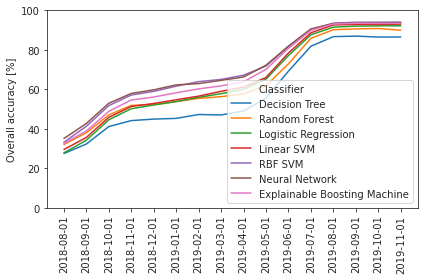

time: 345 ms


In [16]:
# If you loop over random seeds, the confidence interval can be made just by setting ci='std'
df_overall = df_clf_results[df_clf_results['Crop type'] == 'Overall'].astype({'Accuracy': 'float64'})
# I made an error. 2019-11-01 should have been the last date, so remove 2019-12-01.
df_overall = df_overall[df_overall['Date'] != '2019-12-01']  
df_overall['Accuracy'] = df_overall['Accuracy'] * 100

# Plot
#plt.figure(figsize=(20,8)) 
ax = sns.lineplot(x="Date", y="Accuracy", hue='Classifier', ci='sd', 
                  data=df_overall.sort_index(ascending=False))
ax.set_ylabel('Overall accuracy [%]')
ax.set_xlabel('')
ax.set_ylim(0, 100) 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
save_path = PROJ_PATH / 'reports' / 'figures' / 'ClassifierDuringSeason.pdf'
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(save_path)

In [17]:
df_overall[df_overall['Classifier']=='Decision Tree']

,Classifier,Date,Crop type,Prec.,Recall,F1-Score,Accuracy,Samples,Random seed
169,Decision Tree,2019-11-01,Overall,0.870148,0.865188,0.866912,86.518797,13300.0,0
260,Decision Tree,2019-10-01,Overall,0.868124,0.865048,0.866168,86.504774,13301.0,0
351,Decision Tree,2019-09-01,Overall,0.873774,0.869784,0.871247,86.978423,13301.0,0
442,Decision Tree,2019-08-01,Overall,0.874652,0.867163,0.869945,86.716283,13302.0,0
533,Decision Tree,2019-07-01,Overall,0.837476,0.818462,0.825489,81.846200,13303.0,0
624,Decision Tree,2019-06-01,Overall,0.711074,0.692325,0.697794,69.232504,13303.0,0
715,Decision Tree,2019-05-01,Overall,0.591807,0.555998,0.565254,55.599820,13304.0,0
806,Decision Tree,2019-04-01,Overall,0.508652,0.490492,0.494770,49.049230,13305.0,0
897,Decision Tree,2019-03-01,Overall,0.494019,0.470354,0.473785,47.035395,13307.0,0
988,Decision Tree,2019-02-01,Overall,0.494927,0.472613,0.478703,47.261252,13309.0,0


time: 30.4 ms


In [18]:
df_overall.groupby(['Classifier', 'Date'])['Accuracy'].mean().to_frame()

# NOTE: Take a look at below on how to get min and max values
# See https://stackoverflow.com/a/46501773/12045808
#df = (df.assign(Data_Value=df['Data_Value'].abs())
#       .groupby(['Day'])['Data_Value'].agg([('Min' , 'min'), ('Max', 'max')])
#       .add_prefix('Day'))

Accuracy
Classifier    Date                 
Decision Tree 2018-08-01  27.480516
              2018-09-01  32.315426
              2018-10-01  41.160574
              2018-11-01  44.171549
              2018-12-01  44.937660
...                             ...
Random Forest 2019-07-01  85.875366
              2019-08-01  90.227034
              2019-09-01  90.632283
              2019-10-01  90.827757
              2019-11-01  89.947368

[112 rows x 1 columns]

time: 28.6 ms


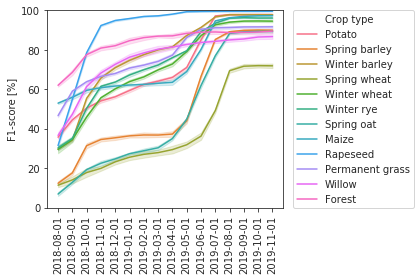

time: 744 ms


In [39]:
# Select classifier to plot
df_crop = df_clf_results[df_clf_results['Classifier'] == 'RBF SVM']
df_crop = df_crop[df_crop['Date'] != '2019-12-01']  # Made an error (2019-11-01 is actually the last date)
df_crop['F1-Score'] = df_crop['F1-Score'] * 100

# Drop the 'Overall' results and only use the individual crop types
df_crop = df_crop[df_crop['Crop type'] != 'Overall']

#Plot
#plt.figure(figsize=(20,8)) 
# Define markers 
# Note: Markers are not working in lineplots 
# (see https://github.com/mwaskom/seaborn/issues/1513#issuecomment-480261748)
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D')
# Take a look at:
# https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
# and
# https://seaborn.pydata.org/generated/seaborn.lineplot.html

ax = sns.lineplot(x="Date", y="F1-Score", hue='Crop type', data=df_crop.sort_index(ascending=False), ci='sd')
ax.set_ylabel('F1-score [%]')
ax.set_xlabel('')
ax.set_ylim(0, 100)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
ax.legend(bbox_to_anchor=(1.04, 1.0), loc=2, borderaxespad=0.)
#ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

save_path = PROJ_PATH / 'reports' / 'figures' / 'ClassifierDuringSeasonCrop.pdf'
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(save_path)